### GANs for data augmentation: vanilla GANs
In this series of notebooks we try different types of GANs for data augmentation. This notebook is dedicated to vanilla GANs, but in the same repository you can find different notebooks for Deep Convolutional GANs (DCGANs), Conditional GANs (CGANs), Auxiliary Classifier GANs (ACGANs) and Prescribed GANs (PresGANs). We use the Fashion MNIST dataset which contains 60,000 grayscale images of size 28x28, with 10 different classes of clothing and accessory items.

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import sys
import numpy as np
import keras
import pandas as pd
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def load_fashion_mnist(input_rows, input_cols, path='fashion-mnist_train.csv'):
    #read the csv data
    df = pd.read_csv(path)
            
    #extract the images
    X_train = df.drop(columns = ['label']).values
    X_train = X_train.reshape(X_train.shape[0], input_rows, input_cols)
            
    #extract the labels
    y_train = df['label'].values

    return X_train, y_train
        
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], 
                 save_all=True, duration=int(1000/fps), loop=loop)
    
def plot_gan_losses(g_loss, d_loss):
    "Plot generator and discriminator loss over each epoch"
    plt.plot(g_loss)
    plt.plot(d_loss)
    plt.title('GANs Losses')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

In [3]:
class GAN():
    def __init__(self):
        self.img_rows = 28           # fashion MNIST images shape 28 x 28
        self.img_cols = 28
        self.channels = 1            # Grayscale images
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100        # latent dimension
        
        optimizer = Adam(5e-4, 0.05) # (learning rate, weight decay)     
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])        
        
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(img)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_generator(self):
        "Generator architecture"
        model = Sequential()
        model.add(Dense(64, input_dim=self.latent_dim)) #32 - 64 - 128
        model.add(LeakyReLU(alpha=0.2)) #alpha=0.2
        model.add(BatchNormalization(momentum=0.9))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)
        
    def build_discriminator(self):
        "Discriminator architecture"
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape)) #512 - 256
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2)) # alpha = 0.2
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):              
        X_train, _ = load_fashion_mnist(28,28)
        X_train = (X_train - 127.5) / 127.5                                 # Normalize images in the range[-1,1]
        X_train = np.expand_dims(X_train, axis=3)        
    
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        GLOSS = np.zeros(epochs)
        DLOSS = np.zeros(epochs)
        
        files = []
        print("Epoch progress:")
        progbar = tf.keras.utils.Progbar(epochs-1)                          # progress bar
        
        for epoch in range(epochs):    
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]    
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))   # generate random noise   
            gen_imgs = self.generator.predict(noise)                        # pass noise through generator
                                                                            # to generate images

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)    # train discriminator on real images
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake) # train discriminator on fake images
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)                 # combine discriminator losses
            
            DLOSS[epoch] = d_loss[0]                                        # discriminator loss over each epoch
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)             # train generator
            GLOSS[epoch] = g_loss                                           # generator loss over each epoch

            if epoch % sample_interval == 0:
                #print(' Epoch ', epoch)
                f = self.sample_images(epoch)
                files.append(f)
            
            progbar.update(epoch)                                           # update progress bar
            
        plt.close("all")
        save_gif_PIL("vangan_0.gif", files, fps=10, loop=0) # save gif

        return GLOSS, DLOSS
        
    def sample_images(self, epoch):
        np.random.seed(seed=42)
        r, c = 4, 4 # rows and columns for the subplots
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)        
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        file = "images/"+str(epoch)+".png"
        plt.text(-90,47,"(vanilla) GANs - epoch: %i"%(epoch),fontsize="large",color="k")
        fig.savefig(file)
        #plt.show()
        plt.close("all")
        
        return file

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 513       
Total params: 1,329,153
Trainable params: 1,329,153
Non-trainable params: 0
____________________________________________

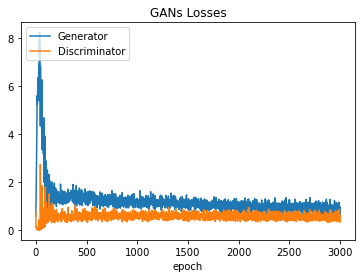

In [19]:
gan = GAN()
GLOSS, DLOSS = gan.train(epochs=3001, batch_size=16, sample_interval=200)
plot_gan_losses(GLOSS, DLOSS)

![SegmentLocal](vangan_0.gif "gif")

#### Compare generated image to closest original samples

In [5]:
def plot_n_closest(img_smp, id_label_sample, X_train, N_closest, fig_size=(8, 3)):
    
    idx_lab = np.where(y_train==id_label_sample)                    # index of images that belong to id_label_sample
    X_lab = (X_train[idx_lab, :, :].astype(np.float32) / 255)[0, :, :, :]  # images of the id_label_sample class

    #apply the norm between X_lab and the sampled image across all images
    L1_dis = np.sum(np.apply_along_axis(np.linalg.norm, -1, X_lab - img_smp, ord=1), axis=1) # Manhattan distance

    idx_l1_sort = L1_dis.argsort() # sort to find N closest images
    fig, axs = plt.subplots(1, N_closest, figsize=fig_size)
    plt.text(-78,-5,'Closest original samples')
    
    for i in range(N_closest):
        axs[i].imshow(X_lab[idx_l1_sort[i], :, :], cmap='gray')
        axs[i].axis('off')
    plt.show()

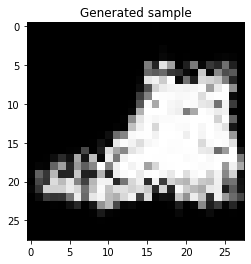

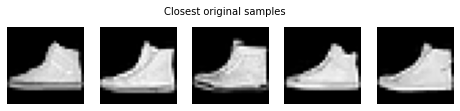

In [18]:
id_label_sample = 7

epsilon_smp = np.random.normal(0, 1, (1, 100))           # another sample noise
img_smp = gan.generator.predict(epsilon_smp)[0, :, :, 0] # generate image
img_smp = img_smp * 0.5 + 0.5                            # normalize to range[0,1]
X_train, y_train = load_fashion_mnist(28,28)

plt.imshow(img_smp, cmap='gray')                         # plot generated sample
plt.title('Generated sample')
plt.show()

plot_n_closest(img_smp, id_label_sample, X_train, 5, fig_size=(8, 8)) # plot N closest original samples